# Imports

In [1]:
!pip install --quiet transformers datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.7 MB/s eta 0:00:00


In [10]:
from datasets import load_dataset_builder
from datasets import load_dataset
import transformers
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch
from torch.utils.data import DataLoader
import gc

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Model

In [ ]:
model_name = "google/pegasus-xsum"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
model.eval()

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(512, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_nor

In [ ]:
model.config

PegasusConfig {
  "_name_or_path": "google/pegasus-xsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 0,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,


In [ ]:
# Helper function to get decoder last layer hidden states

# https://github.com/huggingface/transformers/issues/21374

def extract_decoder_hidden_states(
    generate_output_dict,
    hidden_layer_idx=-1,
):
    """
    Extracts the decoder hidden states representation from
    GreedySearchEncoderDecoderOutput and BeamSearchEncoderDecoderOutput,
    associated with the `sequences` output.
    - generate_output_dict: output dict from the model.generate() method
      you should add the following arguments to generate:
        - output_hidden_states=True
        - output_scores=True
        - return_dict_in_generate=True
    - hidden_layer_idx: index of the layer to extract the representation from (-1 == last one)
    """
    greedy = isinstance(generate_output_dict, transformers.generation.utils.GreedySearchEncoderDecoderOutput)
    beamy  = isinstance(generate_output_dict, transformers.generation.utils.BeamSearchEncoderDecoderOutput)

    if greedy:
        # in greedy decoding, the beam_indices is not present, so we create one
        # where the first beam is always selected
        scores = generate_output_dict['scores']
        device = generate_output_dict['sequences'].device
        beam_indices = torch.arange(scores[0].shape[0]).view(-1, 1)
        beam_indices = beam_indices.expand(-1, len(scores)).to(device)
    elif beamy:
        if 'beam_indices' not in generate_output_dict:
            raise RuntimeError(
                "You should export the scores with output_scores=True when " \
                "calling extract_decoder_hidden_states with " \
                "BeamSearchEncoderDecoderOutput"
            )
        beam_indices = generate_output_dict['beam_indices'].clone()
    else:
        raise NotImplementedError(
            "extract_decoder_hidden_states only works with " \
            "GreedySearchEncoderDecoderOutput and BeamSearchEncoderDecoderOutput " \
            "output types."
        )

    # handling of the target length and preparing the masking for tokens
    # outside of that length
    beam_indices_mask = beam_indices < 0
    max_beam_length = (1 - beam_indices_mask.long()).sum(-1).max()
    beam_indices = beam_indices[:, :max_beam_length]
    beam_indices_mask = beam_indices_mask[:, :max_beam_length]
    beam_indices[beam_indices_mask] = 0

    seqlen = generate_output_dict['sequences'].shape[1] - 1

    # creating the output hidden_states representation in format:
    # [bsz * beam_width ; seqlen ; featdim]
    decoder_hidden_states = torch.stack([
        generate_output_dict['decoder_hidden_states'][i][hidden_layer_idx][:,0,:].index_select(     # [:,0,:] is to get the first sequence
                                                                                                    # e.g., "1" in above [29,17,16,1,1024]
            dim=0,
            index=beam_indices[:,i] # reordering using the beam_indices
        )
        for i in range(seqlen)
    ]).transpose(0, 1)

    # setting to 0 the hidden_states were it doesn't make sense to have an output
    decoder_hidden_states[beam_indices_mask] = 0

    return decoder_hidden_states

# Xsum Dataset

In [ ]:
ds_builder = load_dataset_builder("xsum")
print(ds_builder.info.description)
print(ds_builder.info.features)


Extreme Summarization (XSum) Dataset.

There are three features:
  - document: Input news article.
  - summary: One sentence summary of the article.
  - id: BBC ID of the article.


{'document': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


In [ ]:
dataset = load_dataset("xsum")
dataset

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [ ]:
for k, v in dataset["train"][0].items():
    print(k,'=',v)
    print()

In [ ]:
batch_size = 8
all_encoder_last_hidden_states = []
all_decoder_last_hidden_states = []

In [ ]:
with torch.no_grad():
    for i in range(0, len(dataset["test"]), batch_size):
        batch = tokenizer(dataset["test"][i:min(i+batch_size,len(dataset["test"]))]["document"], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch, output_hidden_states=True, output_scores=True, return_dict_in_generate=True)
        encoder_hidden_states = (outputs.encoder_hidden_states[-1]).mean(axis=1).to("cpu")      # mean over sequence
        decoder_hidden_states = (extract_decoder_hidden_states(outputs)).mean(axis=1).to("cpu")
        for j in range(encoder_hidden_states.shape[0]):
            all_encoder_last_hidden_states.append(encoder_hidden_states[j,:].reshape(1,-1))
            all_decoder_last_hidden_states.append(decoder_hidden_states[j,:].reshape(1,-1))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
all_encoder_last_hidden_states = torch.cat(all_encoder_last_hidden_states, dim=0)
all_decoder_last_hidden_states = torch.cat(all_decoder_last_hidden_states, dim=0)
torch.save({
    "encoder": all_encoder_last_hidden_states,
    "decoder": all_decoder_last_hidden_states
}, "result_xsum.pt")

# C4 Dataset

In [ ]:
ds_builder = load_dataset_builder("stas/c4-en-10k")
print(ds_builder.info.description)
print(ds_builder.info.features)

This is a small subset representing the first 10K records of the original C4 dataset, "en" subset - created for testing. The records were extracted after having been shuffled.

The full 1TB+ dataset is at https://huggingface.co/datasets/c4.

{'text': Value(dtype='string', id=None)}


In [ ]:
dataset = load_dataset("stas/c4-en-10k")
dataset

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset c4-en-10k downloaded and prepared to /root/.cache/huggingface/datasets/stas___c4-en-10k/plain_text/1.0.0/edbf1ff8b8ee35a9751a7752b5e93a4873cc7905ffae010ad334a2c96f81e1cd. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 10000
    })
})

In [ ]:
print(dataset.keys())
print(len(dataset["train"]))
for k, v in dataset["train"][0].items():
    print(k,'=',v)
    print()

dict_keys(['train'])
10000
text = Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.
The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.



In [ ]:
batch_size = 8
all_encoder_last_hidden_states = []
all_decoder_last_hidden_states = []

In [ ]:
with torch.no_grad():
    for i in range(0, len(dataset["train"]), batch_size):
        batch = tokenizer(dataset["train"][i:min(i+batch_size,len(dataset["train"]))]["text"], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch, output_hidden_states=True, output_scores=True, return_dict_in_generate=True)
        encoder_hidden_states = (outputs.encoder_hidden_states[-1]).mean(axis=1).to("cpu")      # mean over sequence
        decoder_hidden_states = (extract_decoder_hidden_states(outputs)).mean(axis=1).to("cpu")
        for j in range(encoder_hidden_states.shape[0]):
            all_encoder_last_hidden_states.append(encoder_hidden_states[j,:].reshape(1,-1))
            all_decoder_last_hidden_states.append(decoder_hidden_states[j,:].reshape(1,-1))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

all_encoder_last_hidden_states = torch.cat(all_encoder_last_hidden_states, dim=0)
all_decoder_last_hidden_states = torch.cat(all_decoder_last_hidden_states, dim=0)
torch.save({
    "encoder": all_encoder_last_hidden_states,
    "decoder": all_decoder_last_hidden_states
}, "result_c4.pt")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# Cnn_dailymail Dataset

In [ ]:
ds_builder = load_dataset_builder("cnn_dailymail", "3.0.0")
print(ds_builder.info.description)
print(ds_builder.info.features)

CNN/DailyMail non-anonymized summarization dataset.

There are two features:
  - article: text of news article, used as the document to be summarized
  - highlights: joined text of highlights with <s> and </s> around each
    highlight, which is the target summary

{'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")
dataset

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})

In [ ]:
print(len(dataset))
for k, v in dataset[0].items():
    print(k,'=',v)
    print()

11490
article = (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesda

In [ ]:
num_test_samples = 2000

indices_taken = torch.randperm(len(dataset))[:num_test_samples] # saved in .pt file
dataset_taken = dataset[indices_taken]["article"]
print(len(dataset_taken))

2000


In [ ]:
batch_size = 8
all_encoder_last_hidden_states = []
all_decoder_last_hidden_states = []

In [ ]:
with torch.no_grad():
    for i in range(0, len(dataset_taken), batch_size):
        print(i, end=' ')
        batch = tokenizer(dataset_taken[i:min(i+batch_size,len(dataset_taken))], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch, output_hidden_states=True, output_scores=True, return_dict_in_generate=True)
        encoder_hidden_states = (outputs.encoder_hidden_states[-1]).mean(axis=1).to("cpu")      # mean over sequence
        decoder_hidden_states = (extract_decoder_hidden_states(outputs)).mean(axis=1).to("cpu")
        for j in range(encoder_hidden_states.shape[0]):
            all_encoder_last_hidden_states.append(encoder_hidden_states[j,:].reshape(1,-1))
            all_decoder_last_hidden_states.append(decoder_hidden_states[j,:].reshape(1,-1))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

all_encoder_last_hidden_states = torch.cat(all_encoder_last_hidden_states, dim=0)
all_decoder_last_hidden_states = torch.cat(all_decoder_last_hidden_states, dim=0)

0 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 472 480 488 496 504 512 520 528 536 544 552 560 568 576 584 592 600 608 616 624 632 640 648 656 664 672 680 688 696 704 712 720 728 736 744 752 760 768 776 784 792 800 808 816 824 832 840 848 856 864 872 880 888 896 904 912 920 928 936 944 952 960 968 976 984 992 1000 1008 1016 1024 1032 1040 1048 1056 1064 1072 1080 1088 1096 1104 1112 1120 1128 1136 1144 1152 1160 1168 1176 1184 1192 1200 1208 1216 1224 1232 1240 1248 1256 1264 1272 1280 1288 1296 1304 1312 1320 1328 1336 1344 1352 1360 1368 1376 1384 1392 1400 1408 1416 1424 1432 1440 1448 1456 1464 1472 1480 1488 1496 1504 1512 1520 1528 1536 1544 1552 1560 1568 1576 1584 1592 1600 1608 1616 1624 1632 1640 1648 1656 1664 1672 1680 1688 1696 1704 1712 1720 1728 1736 1744 1752 1760 1768 1776 1784 1792 1800 1808 1816 18

In [ ]:
torch.save({
    "indices_taken": indices_taken,     # as only some are taken
    "encoder": all_encoder_last_hidden_states,
    "decoder": all_decoder_last_hidden_states
}, "result_cnn_dailymail.pt")

# Fit in-domain and background Gaussians

In [3]:
dataset_names = {
    "indomain": "xsum",
    "background": "c4",
    "ood": "cnn_dailymail"
}

means = {
    "encoder": {},
    "decoder": {}
}
covs = {
    "encoder": {},
    "decoder": {}
}
test_states = {
    "encoder": {},
    "decoder": {}
}

In [4]:
for k, v in dataset_names.items():
    saved_embed = torch.load(f"result_{v}.pt")
    all_encoder_last_hidden_states = saved_embed["encoder"]
    all_decoder_last_hidden_states = saved_embed["decoder"]

    # gaussians fit using 8000 samples
    # test: 2000 of xsum, and 2000 of cnn_dailymail

    # num_total = all_encoder_last_hidden_states.shape[0]
    num_total = 10000
    train_fraction = 0.8
    num_train = int(train_fraction*num_total)

    if k != "ood":
        print(k, v, num_total, num_train)
        
        train_encoder = all_encoder_last_hidden_states[:num_train]
        train_decoder = all_decoder_last_hidden_states[:num_train]
        if k == "indomain":
            test_states["encoder"][k] = all_encoder_last_hidden_states[num_train:num_total]
            test_states["decoder"][k] = all_decoder_last_hidden_states[num_train:num_total]

        means["encoder"][k] = torch.mean(train_encoder, 0)
        means["decoder"][k] = torch.mean(train_decoder, 0)
        covs["encoder"][k] = torch.cov(train_encoder.T)
        covs["decoder"][k] = torch.cov(train_decoder.T)
    else:
        print(k, v, all_encoder_last_hidden_states.shape[0])
        assert all_encoder_last_hidden_states.shape[0] == num_total-num_train

        test_states["encoder"][k] = all_encoder_last_hidden_states
        test_states["decoder"][k] = all_decoder_last_hidden_states

indomain xsum 10000 8000
background c4 10000 8000
ood cnn_dailymail 2000


In [5]:
torch.save({
    "means": means,
    "covs": covs,
    "test_states": test_states
}, "means_covs_tests.pt")

In [ ]:
# saved_embed = torch.load("result_c4.pt")
# all_encoder_last_hidden_states = saved_embed["encoder"]
# all_decoder_last_hidden_states = saved_embed["decoder"]

# num_total = 10000
# train_fraction = 0.8
# num_train = int(train_fraction*num_total)
# print(num_total, num_train)

# train_encoder = all_encoder_last_hidden_states[:num_train]
# test_encoder = all_encoder_last_hidden_states[num_train:num_total]
# train_decoder = all_decoder_last_hidden_states[:num_train]
# test_decoder = all_decoder_last_hidden_states[num_train:num_total]

# mean_encoder = torch.mean(train_encoder, 0)
# mean_decoder = torch.mean(train_decoder, 0)
# cov_encoder = torch.cov(train_encoder.T)
# cov_decoder = torch.cov(train_decoder.T)

10000 8000


# RMD and AUROC

In [6]:
def mahalanobis_distance(vectors, mean, cov, epsilon=1e-20):
    """
    vectors: (num_samples, dim)
    mean: dim
    cov: (dim, dim)
    """

    assert vectors.shape[1] == mean.shape[0]
    assert cov.shape[0] == cov.shape[1] and cov.shape[0] == mean.shape[0]

    # add eps*I (prevents singular matrix)
    cov_eps = cov + torch.eye(cov.shape[0])*epsilon
    cov_eps_inv = torch.inverse(cov_eps)

    num_samples = vectors.shape[0]
    out = torch.zeros(num_samples)
    for i in range(num_samples):
        out[i] = ((vectors[i]-mean) @ cov_eps_inv @ (vectors[i]-mean).reshape(-1,1)).item()
    return out

In [7]:
maha_dists = {
    "encoder": {
        "indomain": {},
        "ood": {}
    },
    "decoder": {
        "indomain": {},
        "ood": {}
    }
}

for part in ["encoder", "decoder"]:
    for test in ["indomain", "ood"]:
        for fit_gaussian in ["indomain", "background"]:
            # compute MD of test samples with fitted Gaussians
            maha_dists[part][test][fit_gaussian] = mahalanobis_distance(
                                                        test_states[part][test],
                                                        means[part][fit_gaussian],
                                                        covs[part][fit_gaussian]
                                                    )
torch.save(maha_dists, "maha_dists.pt")

In [18]:
def get_auroc(preds, labels, display=False):
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
    roc_auc = metrics.auc(fpr, tpr)
    if display:
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()
    return roc_auc

tensor(-34870.0703) tensor(8329.2891) tensor(-3784.4580) tensor(4961.5977)
preds.min()=tensor(-34870.0703), preds.max()=tensor(8329.2891)


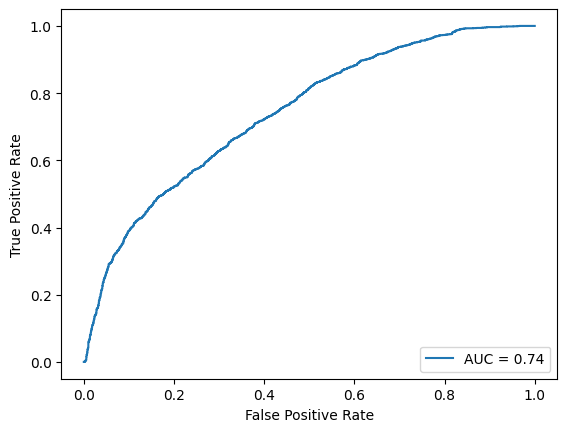

tensor(-6955.5381) tensor(12161.3613) tensor(-3001.3784) tensor(19740.6992)
preds.min()=tensor(-6955.5381), preds.max()=tensor(19740.6992)


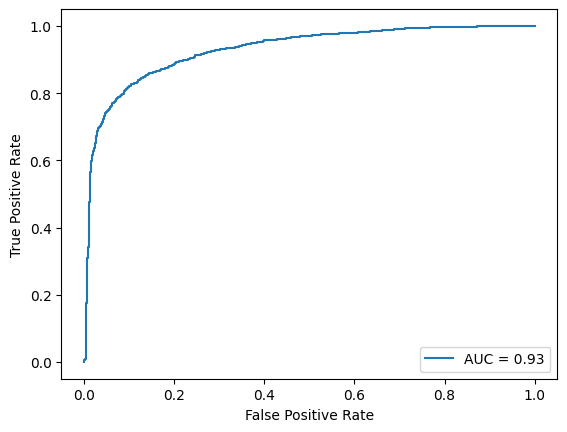

{'encoder': 0.74154525, 'decoder': 0.9288367500000001}


In [19]:
maha_dists = torch.load("maha_dists.pt")

aurocs = {}

for part in ["encoder", "decoder"]:
    rmd_indomain = maha_dists[part]["indomain"]["indomain"] - maha_dists[part]["indomain"]["background"]
    rmd_ood = maha_dists[part]["ood"]["indomain"] - maha_dists[part]["ood"]["background"]
    print(rmd_indomain.min(), rmd_indomain.max(), rmd_ood.min(), rmd_ood.max())     # use scaling? sigmoid?
                                                                                    # sigmoid worsens auroc
    
    # use 0,1 or -1,1? (doesn't appear to change results much currently)
    labels_indomain = torch.zeros_like(rmd_indomain)
    labels_ood = torch.ones_like(rmd_ood)
    
    preds = torch.cat((rmd_indomain, rmd_ood))
    # preds = torch.sigmoid(preds)
    print(f"{preds.min()=}, {preds.max()=}")
    labels = torch.cat((labels_indomain, labels_ood))
    aurocs[part] = get_auroc(preds.cpu().numpy(), labels.cpu().numpy(), display=True)

print(aurocs)

#Earlier Approaches \(no longer used\)

In [ ]:
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [ ]:
from torch.cuda.amp import autocast

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
outputs = []
print(len(dataloader_test))
with torch.no_grad() :
    for batch in dataloader_test:
        # with autocast():
        print(len(batch['input_ids']), batch['input_ids'][0].shape)
        output = model.generate(
                            **batch,
                            output_hidden_states=True, output_scores=True, return_dict_in_generate=True)
        outputs.append(output)
    # torch.cuda.empty_cache()

In [ ]:
import pynvml
print(torch.cuda.list_gpu_processes())


ModuleNotFoundError: ignored